# Proyek: Analisis Prediksi Biaya Medis
## Notebook 00: Business & Data Understanding

**Fase CRISP-ML(Q):** 1. Business Understanding, 2. Data Understanding

**Tujuan:**
1.  Mendefinisikan pertanyaan bisnis yang ingin kita jawab (Business Understanding).
2.  Melakukan Exploratory Data Analysis (EDA) untuk memahami data mentah, menemukan anomali, dan mengidentifikasi pola awal (Data Understanding).

## Fase 1: Business Understanding

Dataset ini, dari perspektif aktuaria/keuangan, digunakan untuk **penetapan harga (pricing)** dan **manajemen risiko (risk management)**.

Kita akan mendefinisikan 4 pertanyaan bisnis utama yang akan dijawab oleh 4 pendekatan pemodelan kita nanti:

1.  **[Regresi]** Berapa perkiraan `charges` (biaya) yang akan ditagih ke seorang nasabah baru berdasarkan fiturnya? (Pertanyaan Pricing)
2.  **[XAI]** Faktor apa (`smoker`, `age`, `bmi`) yang paling signifikan mendorong biaya tersebut, dan seberapa besar? (Pertanyaan Interpretasi Risiko)
3.  **[Klasifikasi]** Bisakah kita memprediksi apakah seorang nasabah akan menjadi "nasabah berbiaya tinggi" (`is_high_cost`)? (Pertanyaan Underwriting)
4.  **[Clustering]** Tanpa mengetahui biayanya, adakah segmen/kelompok alami (`risk pools`) dari nasabah kita? (Pertanyaan Segmentasi Pasar)

## Fase 2: Data Understanding (EDA)

Kita akan memuat data mentah dan melakukan EDA.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Mengatur style visualisasi
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

print("Libraries imported successfully!")

Libraries imported successfully!


### 2.1 Pemuatan Data

Kita akan memuat data dari `data/raw/insurance.csv` (sesuai `README.md`).

In [2]:
RAW_DATA_PATH = '../data/raw/insurance.csv'

try:
    df = pd.read_csv(RAW_DATA_PATH)
    print(f"Data loaded successfully from {RAW_DATA_PATH}")
    print(f"Shape: {df.shape}")
except FileNotFoundError:
    print(f"Error: File not found at {RAW_DATA_PATH}")
    print("Harap unduh dataset dari Kaggle dan letakkan di folder 'data/raw/'")

Data loaded successfully from ../data/raw/insurance.csv
Shape: (1338, 7)


### 2.2 Inspeksi Awal (Data Types & Missing Values)

Langkah pertama adalah selalu `.info()` dan `.describe()`.

In [3]:
print("--- Data Info (Tipe & Non-Null) ---")
df.info()

--- Data Info (Tipe & Non-Null) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [4]:
print("--- Descriptive Statistics (Numerical) ---")
print(df.describe())

--- Descriptive Statistics (Numerical) ---
               age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000     1.000000   9382.033000
75%      51.000000    34.693750     2.000000  16639.912515
max      64.000000    53.130000     5.000000  63770.428010


In [5]:
print("--- Descriptive Statistics (Categorical) ---")
print(df.describe(include=['object']))

--- Descriptive Statistics (Categorical) ---
         sex smoker     region
count   1338   1338       1338
unique     2      2          4
top     male     no  southeast
freq     676   1064        364


**Temuan Awal:**

* **Data Bersih:** Fantastis. Ada 1338 baris dan **tidak ada nilai yang hilang (missing values)** di kolom mana pun. Ini adalah dataset yang sangat bersih.
* **Tipe Data:** Tipe data sudah benar. `age`, `bmi`, `children`, `charges` adalah numerik. `sex`, `smoker`, `region` adalah *object* (kategorikal).
* **Target:** `charges` memiliki `std` (standar deviasi) yang sangat tinggi ($12110) dan `max` ($63770) yang sangat jauh dari `mean` ($13270). Ini adalah tanda **distribusi yang sangat miring (skewed)**.
* **Fitur:** `region` memiliki 4 nilai unik. `smoker` dan `sex` memiliki 2 nilai unik. Semuanya terlihat normal.

### 2.3 Analisis Variabel Target (`charges`)

Kita harus memahami variabel yang ingin kita prediksi. Distribusi yang miring dapat merusak model linear (seperti GLM). Kita akan memeriksanya dengan histogram.

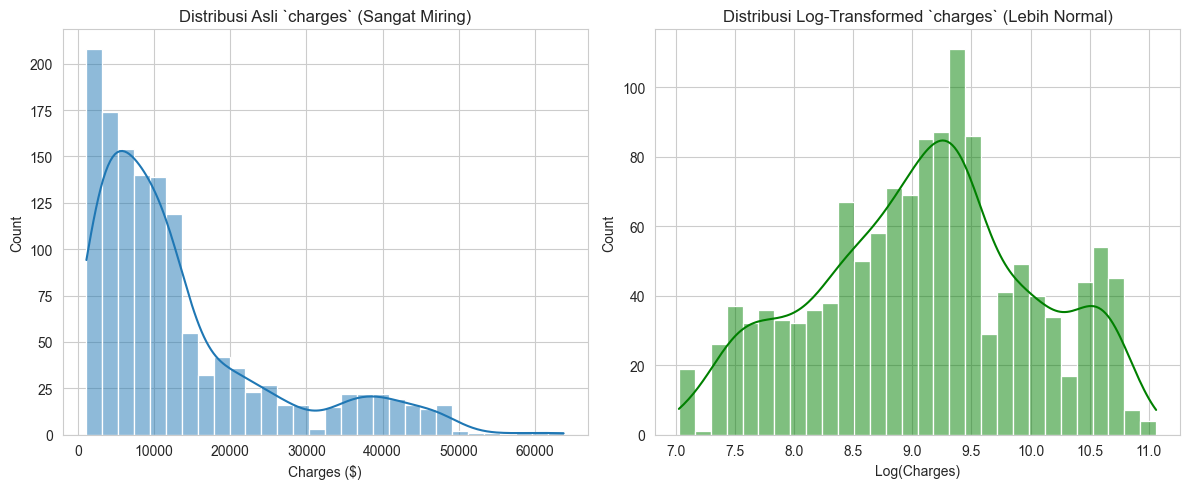

In [6]:
plt.figure(figsize=(12, 5))

# Plot 1: Distribusi Asli
plt.subplot(1, 2, 1)
sns.histplot(df['charges'], kde=True, bins=30)
plt.title('Distribusi Asli `charges` (Sangat Miring)')
plt.xlabel('Charges ($)')

# Plot 2: Distribusi Log-Transformed
plt.subplot(1, 2, 2)
df['log_charges'] = np.log1p(df['charges']) # log1p(x) = log(1+x), aman untuk nilai 0
sns.histplot(df['log_charges'], kde=True, bins=30, color='green')
plt.title('Distribusi Log-Transformed `charges` (Lebih Normal)')
plt.xlabel('Log(Charges)')

plt.tight_layout()
plt.show()

**Temuan Kunci (Hipotesis Pemodelan):**

Distribusi `charges` sangat miring ke kanan (*right-skewed*). Ini adalah temuan umum dalam data biaya/klaim (banyak klaim kecil, sedikit klaim katastrofik).

Model linear (GLM, Linear Regression) mengasumsikan normalitas. Untuk membantu mereka, kita mungkin harus melatih model kita untuk memprediksi `log_charges`, lalu mengkonversinya kembali (eksponen) saat evaluasi.

Model berbasis pohon (Random Forest, XGBoost) **tidak peduli** dengan distribusi ini, yang merupakan salah satu keuntungan besar mereka.

### 2.4 Analisis Fitur (Kategorikal)

Bagaimana fitur kategorikal (`smoker`, `sex`, `region`) berhubungan dengan `charges`?

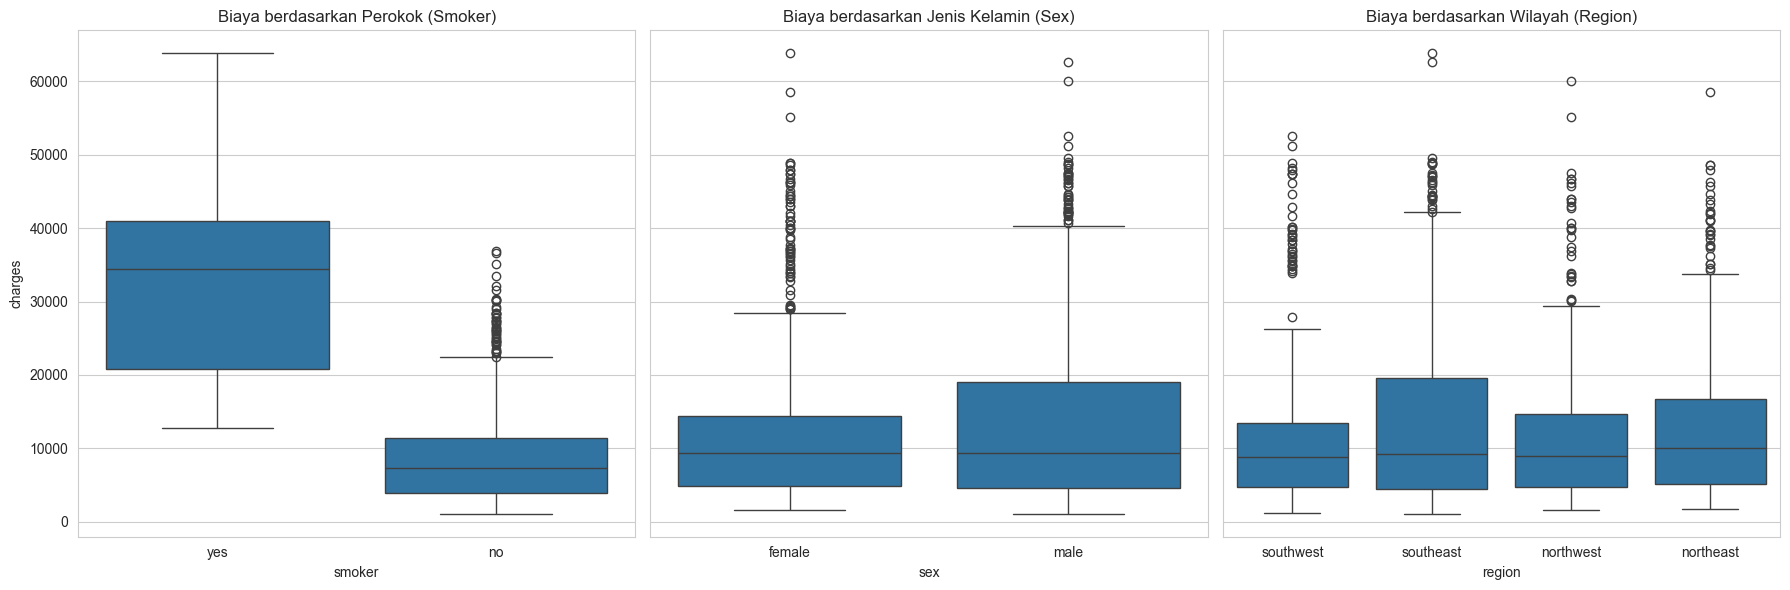

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

sns.boxplot(ax=axes[0], x='smoker', y='charges', data=df)
axes[0].set_title('Biaya berdasarkan Perokok (Smoker)')

sns.boxplot(ax=axes[1], x='sex', y='charges', data=df)
axes[1].set_title('Biaya berdasarkan Jenis Kelamin (Sex)')

sns.boxplot(ax=axes[2], x='region', y='charges', data=df)
axes[2].set_title('Biaya berdasarkan Wilayah (Region)')

plt.tight_layout()
plt.show()

**Temuan Kunci (Hipotesis Fitur):**

* **`smoker` (Perokok):** Ini adalah fitur yang paling **dominan**. Median biaya untuk perokok secara drastis lebih tinggi daripada non-perokok. Ini akan menjadi prediktor nomor satu kita.
* **`sex` (Jenis Kelamin):** Perbedaannya minimal. Median-nya hampir identik.
* **`region` (Wilayah):** Ada sedikit perbedaan (Southeast tampak sedikit lebih mahal), tetapi tidak ada perbedaan signifikan seperti `smoker`.

### 2.5 Analisis Fitur (Numerik)

Bagaimana fitur numerik (`age`, `bmi`, `children`) berhubungan dengan `charges`? Kita akan gunakan *scatterplot*.

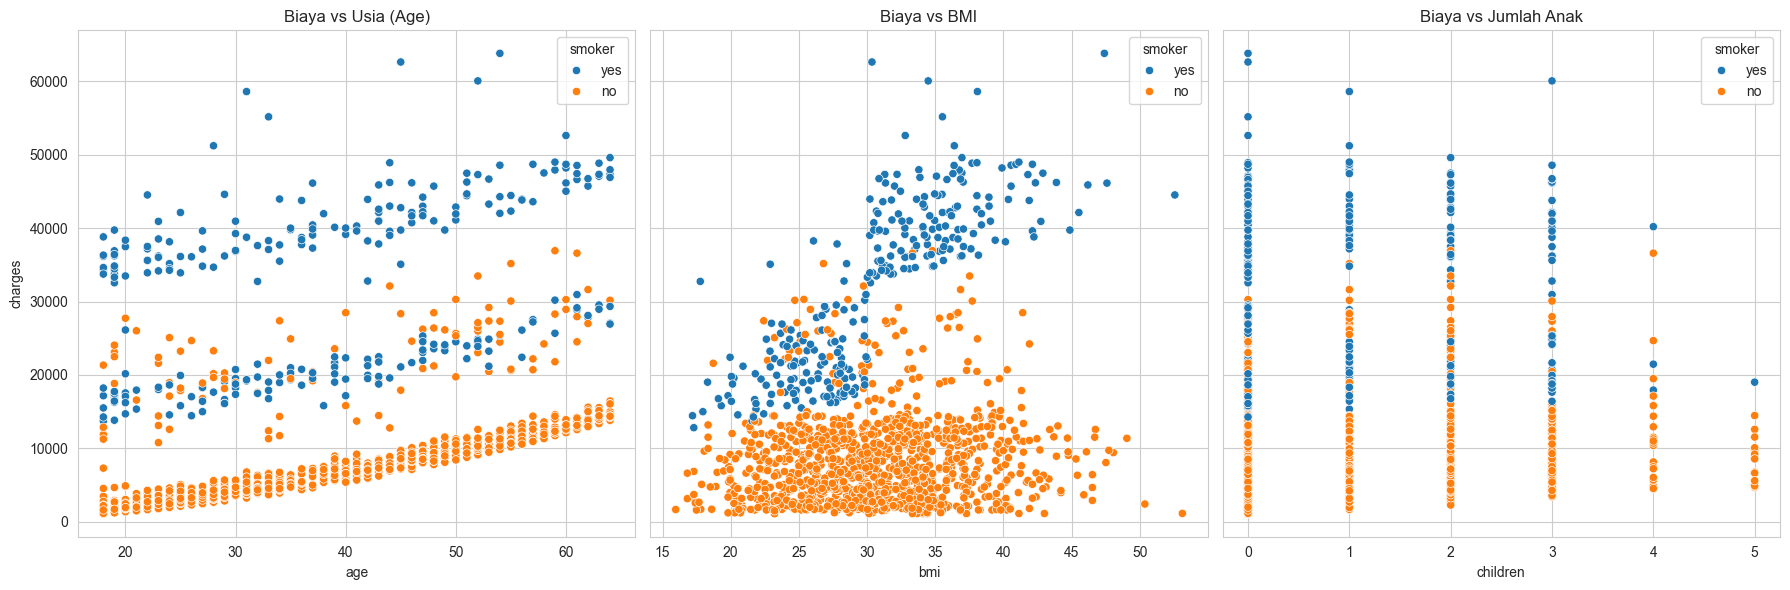

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Kita akan membedakan warnanya berdasarkan 'smoker' untuk melihat interaksi
sns.scatterplot(ax=axes[0], x='age', y='charges', data=df, hue='smoker')
axes[0].set_title('Biaya vs Usia (Age)')

sns.scatterplot(ax=axes[1], x='bmi', y='charges', data=df, hue='smoker')
axes[1].set_title('Biaya vs BMI')

sns.scatterplot(ax=axes[2], x='children', y='charges', data=df, hue='smoker')
axes[2].set_title('Biaya vs Jumlah Anak')

plt.tight_layout()
plt.show()

**Temuan Kunci (Hipotesis Interaksi):**

* **`age` (Usia):** Ada korelasi positif yang jelas. Semakin tua, semakin tinggi biayanya. Namun, plot ini menunjukkan **tiga "pita" (band)** biaya yang terpisah untuk non-perokok, yang menarik.
* **`bmi` (BMI):** Untuk non-perokok (biru), BMI tidak memiliki banyak efek. Tapi untuk perokok (oranye), ada **korelasi positif yang kuat**. Di atas BMI ~30, biaya untuk perokok meningkat tajam. Ini adalah **interaksi fitur** klasik yang mungkin gagal ditangkap oleh model linear sederhana.
* **`children` (Anak):** Tidak ada pola yang jelas. Biaya tersebar di semua jumlah anak.

### 2.6 Matriks Korelasi

Terakhir, kita lihat korelasi antar semua variabel numerik.

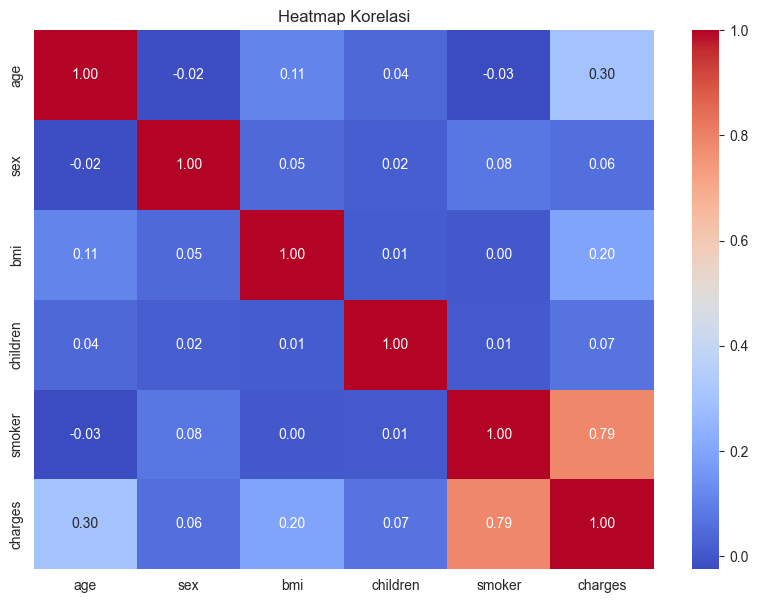

In [9]:
# Untuk heatmap, kita perlu data numerik saja
# Kita akan lakukan one-hot encoding cepat di sini hanya untuk korelasi
df_corr = df.copy()
df_corr['smoker'] = df_corr['smoker'].map({'yes': 1, 'no': 0})
df_corr['sex'] = df_corr['sex'].map({'male': 1, 'female': 0})

# Kita bisa abaikan 'region' dan 'log_charges' untuk heatmap ini
df_corr = df_corr.drop(columns=['region', 'log_charges'])

plt.figure(figsize=(10, 7))
corr_matrix = df_corr.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Heatmap Korelasi')
plt.show()

**Temuan Kunci (Konfirmasi):**

* **`smoker`:** Memiliki korelasi **0.79** dengan `charges`. Ini menegaskan temuan visual kita: `smoker` adalah prediktor tunggal terkuat.
* **`age`:** Korelasi **0.30** dengan `charges` (positif).
* **`bmi`:** Korelasi **0.20** dengan `charges` (positif lemah).
* Fitur-fitur lain memiliki korelasi yang sangat lemah dengan `charges`.

## Kesimpulan Fase 0 & 1

Kita telah menyelesaikan Fase Business & Data Understanding.

**Hipotesis Utama untuk Pemodelan:**
1.  **Target:** `charges` sangat miring. Kita perlu memprediksi `log(charges)` untuk model linear (GLM), tetapi bisa menggunakan `charges` asli untuk model pohon (XGBoost).
2.  **Fitur Penting:** `smoker` akan menjadi fitur #1. `age` dan `bmi` akan menjadi #2 dan #3.
3.  **Interaksi Fitur:** Ada interaksi yang kuat antara `bmi` dan `smoker` yang harus ditangkap oleh model kita untuk akurasi maksimal.
4.  **Fitur Tidak Penting:** `sex` dan `children` kemungkinan memiliki pengaruh yang sangat kecil.
5.  **Kualitas Data:** Data sudah bersih, tidak perlu imputasi (penanganan *missing value*).

Kita siap untuk **Langkah 01: Data Preparation**.